In [90]:
!pip install keras==2.3.1
#%tensorflow_version 1.x
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical
from numpy import asarray
from pathlib import Path
import cv2
import numpy as np

from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint,EarlyStopping
from numpy import load
from google.colab.patches import cv2_imshow
from google.colab import drive
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import classification_report

In [91]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [92]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def getListOfImages(source):
     return list(Path(source).glob('**/*.png'))    

def readImages(images,img_width,img_height):
    X=[]
    Y=[]
    for imagePath in images:
        imagePath = str(imagePath)
        imgArr = cv2.imread(imagePath)
        imgArr = cv2.resize(imgArr, (img_width, img_height)) 
        X.append(imgArr)
        Y.append(int(imagePath.split("/")[-1].split("-")[0][3:]) - 1)
    X = asarray(X)
    Y = asarray(Y)
    return (X,Y)

In [0]:
num_classes = 62
img_width = 64
img_height = 64
channels=3
source = '/content/drive/My Drive/CMPE256/src'

In [0]:
#images = getListOfImages(source+'/Data')

In [0]:
#Takes a lot of time on google colab hence save the data into npz format and directly load it
#%time X,y = readImages(images,img_width,img_height)

In [0]:
#y = to_categorical(y)

In [98]:
X = load(source+'/Data/images.npz')
y = load(source+'/Data/labels.npz')
X = X['arr_0']
y = y['arr_0']
num_samples = len(X)
print(X.shape,y.shape)

(74107, 64, 64, 3) (74107, 62)


In [0]:
#normalization
X = X/255.0

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

In [0]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,stratify=y_train, test_size=0.2, random_state=42)

In [102]:
print("Training set : ",X_train.shape,len(X_train)/num_samples * 100 , "% of total samples")
print("Testing set : ",X_test.shape, len(X_test)/num_samples * 100 , "% of total samples")
print("Validation set : ",X_validation.shape, len(X_validation)/num_samples * 100 , "% of total samples")

Training set :  (47428, 64, 64, 3) 63.99935228790803 % of total samples
Testing set :  (14822, 64, 64, 3) 20.00080964011497 % of total samples
Validation set :  (11857, 64, 64, 3) 15.999838071977008 % of total samples


In [103]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(img_width, img_height, channels), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D())
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

lrate=0.01
epochs = 100
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 512)      

In [0]:
#checkpoint
filepath= source+"/models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max',period=10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
callbacks_list = [checkpoint,es]

In [105]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=32,callbacks=callbacks_list)

Train on 47428 samples, validate on 11857 samples
Epoch 1/100
47428/47428 [==============================] - 52s 1ms/step - loss: 1.7141 - accuracy: 0.5547 - val_loss: 0.6476 - val_accuracy: 0.7973
Epoch 2/100
47428/47428 [==============================] - 52s 1ms/step - loss: 0.6217 - accuracy: 0.7980 - val_loss: 0.4771 - val_accuracy: 0.8354
Epoch 3/100
47428/47428 [==============================] - 52s 1ms/step - loss: 0.4482 - accuracy: 0.8426 - val_loss: 0.4093 - val_accuracy: 0.8510
Epoch 4/100
47428/47428 [==============================] - 52s 1ms/step - loss: 0.3557 - accuracy: 0.8664 - val_loss: 0.3778 - val_accuracy: 0.8632
Epoch 5/100
47428/47428 [==============================] - 52s 1ms/step - loss: 0.2931 - accuracy: 0.8890 - val_loss: 0.3418 - val_accuracy: 0.8748
Epoch 6/100
47428/47428 [==============================] - 52s 1ms/step - loss: 0.2473 - accuracy: 0.9034 - val_loss: 0.3232 - val_accuracy: 0.8830
Epoch 7/100
47428/47428 [==============================] - 52s

In [106]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.59%


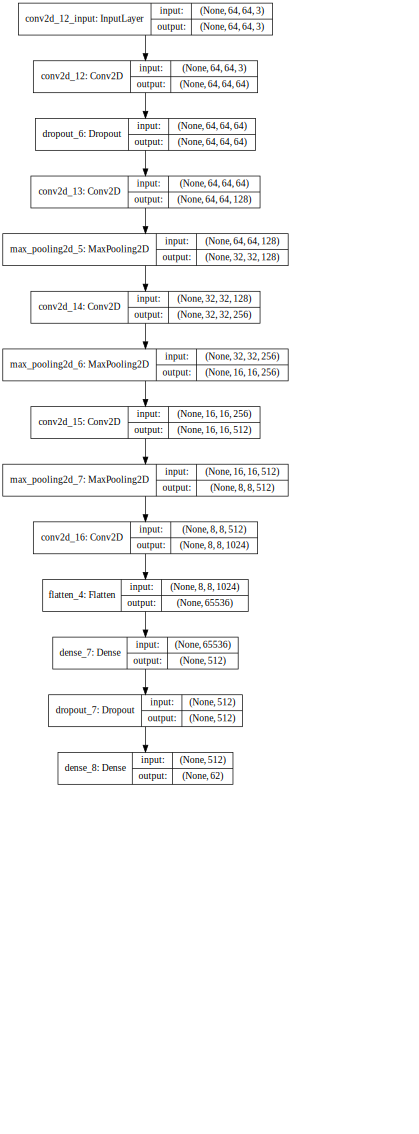

In [107]:
from IPython.display import SVG
from keras.utils import model_to_dot
#model
SVG(model_to_dot(model,show_shapes=True,expand_nested=True,dpi=50).create(prog='dot', format='svg'))

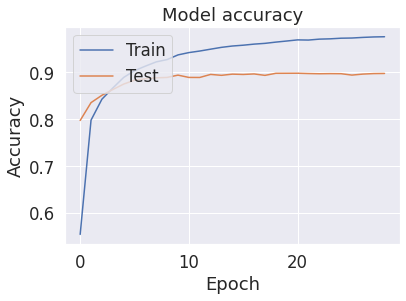

In [108]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

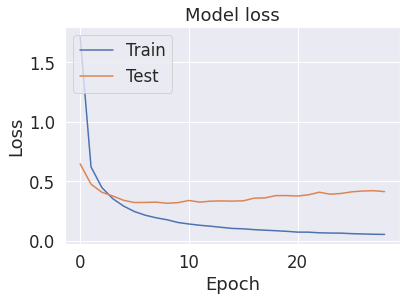

In [109]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def createConfusionMatrix(trueLabel,PredictedLabel):
    cm=confusion_matrix(trueLabel,PredictedLabel,normalize="true")
    return np.around(cm, decimals=2)

In [0]:
def plotConfusionMatrix(matrix):
  df_cm = pd.DataFrame(matrix,range(matrix.shape[0]),range(matrix.shape[1]))
  plt.figure(figsize = (50,50))
  sn.set(font_scale=1.5)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) 

In [0]:
#Get the predicted classes for all the samples in testing set
y_pred = model.predict_classes(X_test)

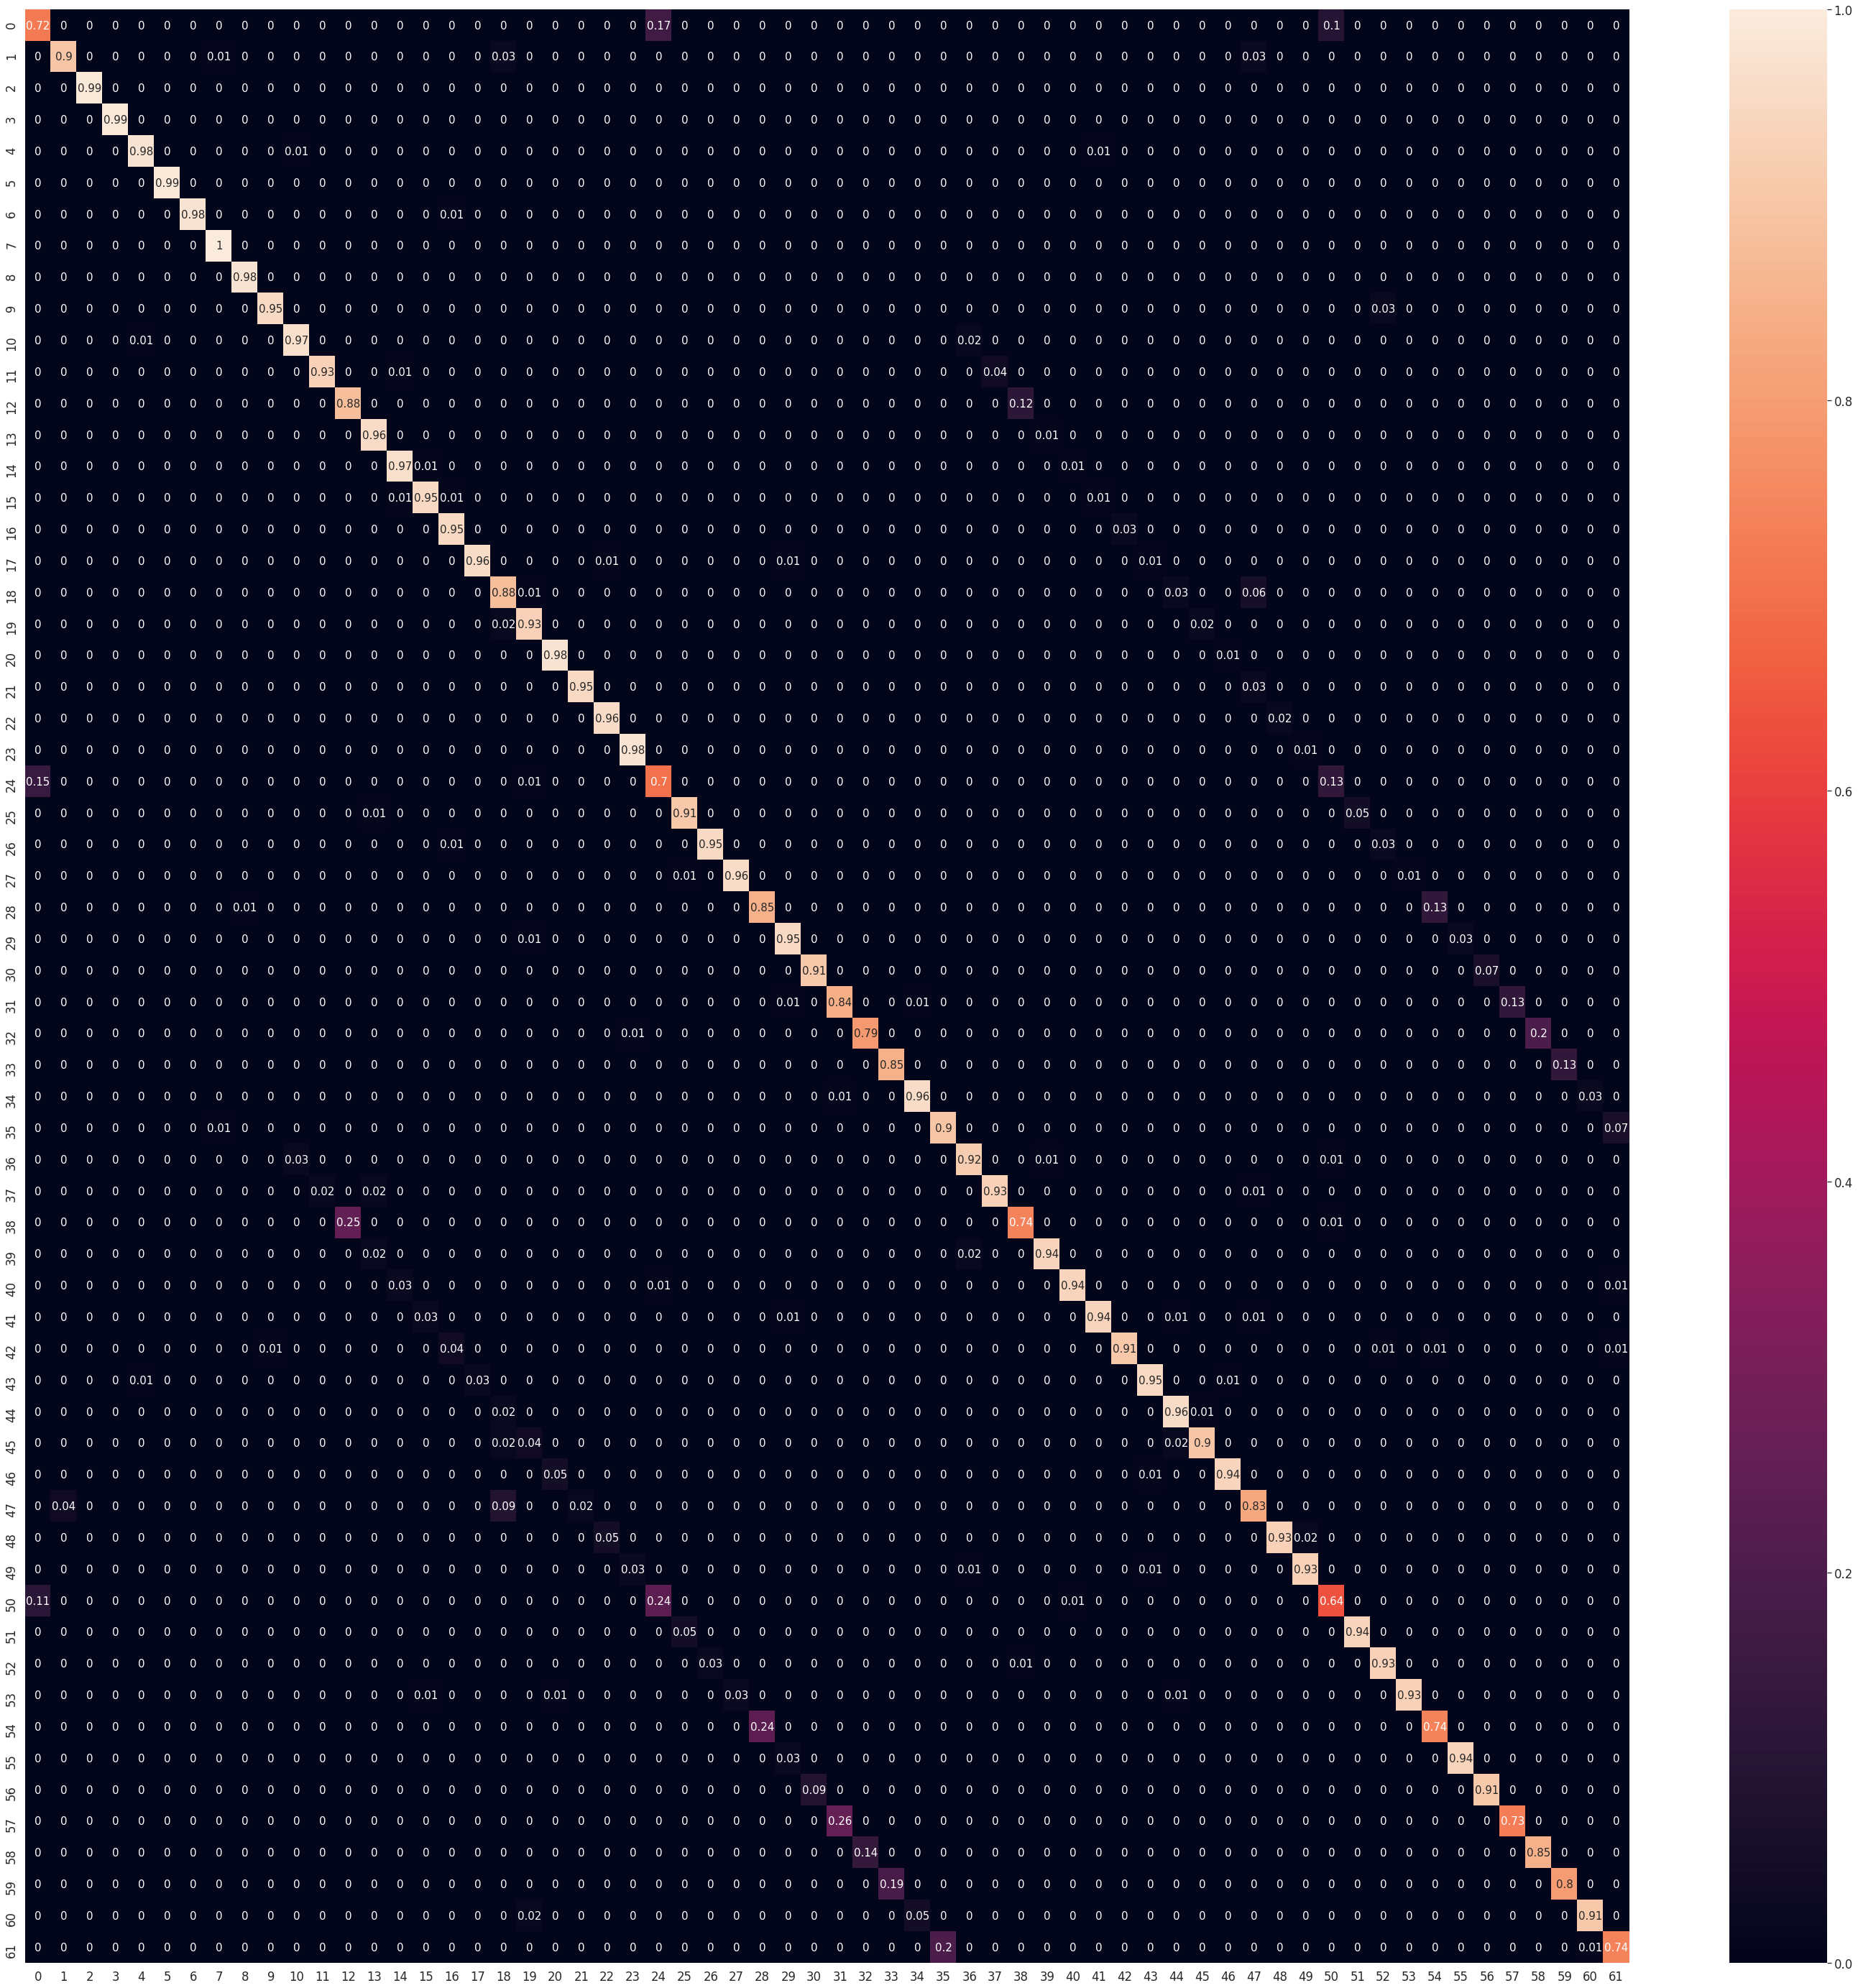

In [113]:
#Create and plot the confusion matrix
cm = createConfusionMatrix(y_test.argmax(axis=1),y_pred)
plotConfusionMatrix(cm)

In [114]:
print(classification_report(y_test.argmax(axis=1),y_pred,zero_division=0)) 

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       235
           1       0.93      0.90      0.92       230
           2       0.97      0.99      0.98       228
           3       0.99      0.99      0.99       224
           4       0.97      0.98      0.98       224
           5       1.00      0.99      0.99       227
           6       0.99      0.98      0.98       227
           7       0.98      1.00      0.99       224
           8       0.98      0.98      0.98       220
           9       0.98      0.95      0.97       221
          10       0.96      0.97      0.97       326
          11       0.97      0.93      0.95       237
          12       0.78      0.88      0.83       257
          13       0.95      0.96      0.96       252
          14       0.94      0.97      0.95       303
          15       0.94      0.95      0.95       230
          16       0.92      0.95      0.94       243
          17       0.96    